# WildHack@поисковые_тэги  
**Problem statement**

Пользователь видит результат поискового запроса, но не может легко найти нужный товар пролистыванием выдачи:  
товаров слишком много, товар слишком разнообразный либо нужного товара просто нет. Нужно предложить набор поисковых подсказок (тегов),   
которые максимально сократят путь пользователя к искомому товару.


**Requirments**

Необходимо разработать алгоритм формирования поисковых тегов (сопутствующих/связанных запросов), которые помогут пользователю уточнить или дополнить поисковую выдачу и продолжить поиск в случае нерелевантной выдачи.

**Data**

_search_history.csv_

История поиска — реальные данные взятые за определенный период (неделя). 

wbuser_id - обезличенный идентификатор пользователя  
UQ - введенный поисковый запрос  
cnt - количество товаров в выдаче, не считая дополнительных рекомендаций  
locale - локаль сайта, на которой был введен запрос   
weekday - день недели запроса  
time - время запроса


_query_popularity.csv_

query - текст запроса  
query_popularity - относительная популярность запроса за взятый период. 1 наименее популярный, 10 — наиболее

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('C:/Users/Xiaomi/Downloads')

## 1. EDA

In [3]:
df_qp = pd.read_csv('query_popularity.csv')
df_sh = pd.read_csv('search_history.csv', nrows = 5_000_000, date_parser = ['time'])

In [4]:
df_sh.head()

,wbuser_id,UQ,cnt,locale,weekday,time
0,37bc0ce12ffabce1b1882e66d461ed0e,тапочки женские домашние,1933,Ru,0,10:48:53
1,4636a6706e6736d818816d8657565aa2,чехол для бейджика,1513,Ru,0,10:48:53
2,708f4040baf99acfc9496563edff1b1a,GUESS,4,Ru,0,10:48:53
3,70311ec9008a31f743c164e6f1198c86,штора для ванной,0,Ru,0,10:48:53
4,70311ec9008a31f743c164e6f1198c86,фототфон,92272,Ru,0,10:48:53


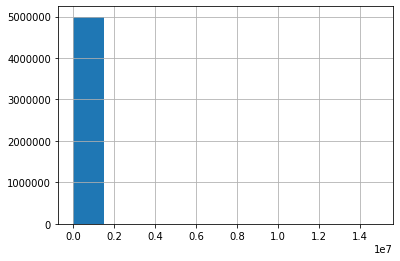

In [5]:
df_sh.cnt.hist(bins = 10) # выбросы - нули в cnt - баги

In [6]:
df_qp.head()

,query,query_popularity
0,ноутбук,10
1,куртка женская осенняя,10
2,ботинки женские,10
3,видеокарта,10
4,пальто женское осеннее,10


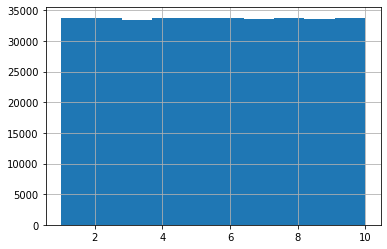

In [7]:
df_qp['query_popularity'].hist()

## 2. Data preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
# dropping weekday number as it's not giving any info
df_sh = df_sh[['wbuser_id', 'UQ', 'locale', 'cnt', 'time']]

In [10]:
# dropping duplicates for group id-uq-cnt
df_sh = df_sh.drop_duplicates(['wbuser_id', 'UQ', 'cnt'])

In [11]:
df_sh['UQ'] = df_sh.UQ.str.replace('ё', 'е')

In [12]:
df_sh['UQ'] = df_sh.UQ.str.strip().str.lower()

In [13]:
# handling zero values in cnt
df_sh['cnt'] = df_sh.groupby('wbuser_id').cnt.transform('max')

In [14]:
# dropping duplicates for group id-uq again after handling zero values in cnt
df_sh = df_sh.drop_duplicates(['wbuser_id', 'UQ'])

In [15]:
df_sh.shape

(2107822, 5)

In [16]:
df_sh.head()

,wbuser_id,UQ,locale,cnt,time
0,37bc0ce12ffabce1b1882e66d461ed0e,тапочки женские домашние,Ru,8954,10:48:53
1,4636a6706e6736d818816d8657565aa2,чехол для бейджика,Ru,1513,10:48:53
2,708f4040baf99acfc9496563edff1b1a,guess,Ru,35142,10:48:53
3,70311ec9008a31f743c164e6f1198c86,штора для ванной,Ru,14867578,10:48:53
4,70311ec9008a31f743c164e6f1198c86,фототфон,Ru,14867578,10:48:53


In [17]:
# dropping numeric values in UQ since most of them are set numbers and lead straight to the item page
dh_sh = df_sh[~(df_sh['UQ'].str.isdigit() == True)]

In [18]:
df_sh.isnull().sum()

wbuser_id    0
UQ           5
locale       0
cnt          0
time         0
dtype: int64

In [19]:
df_sh = df_sh.dropna(subset=['UQ'])

In [20]:
# dropping uq starting with @ as these are just some trash data with reviews(????)
df_sh = df_sh[~(df_sh['UQ'].str[0] == '@')]

In [21]:
le = LabelEncoder()
df_sh['wbuser_id'] = le.fit_transform(df_sh.wbuser_id)

In [22]:
df_sh.head()

,wbuser_id,UQ,locale,cnt,time
0,202223,тапочки женские домашние,Ru,8954,10:48:53
1,254781,чехол для бейджика,Ru,1513,10:48:53
2,408249,guess,Ru,35142,10:48:53
3,406925,штора для ванной,Ru,14867578,10:48:53
4,406925,фототфон,Ru,14867578,10:48:53


## development

### sentence transformer

In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\Xiaomi\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [160]:
%%time
#creating embeddings for 500k corpus of request (UQ)
sentences = df_sh[:500000].UQ.tolist()
sentence_embeddings = model.encode(sentences)

Wall time: 43min 6s


In [311]:
#simple representation vectors
#for sentence, embedding in zip(sentences, sentence_embeddings):
    #print("Sentence:", sentence)
    #print("Embedding:", embedding)
    #print(len(embedding))
    #print("")

In [283]:
#creating DataFrame with query
sent = pd.DataFrame(sentences, columns=['text'])
sent.head()

,text
0,тапочки женские домашние
1,чехол для бейджика
2,guess
3,штора для ванной
4,фототфон


In [294]:
%%time
#choice our UQ (text column in our df sent) == 'тапочки женские домашние' (index == 0 in sentence_embeddings)
df_0 = pd.DataFrame(columns=['UQ', 'cos'])
df_0.UQ = df_sh[:100000].UQ.reset_index(drop=True)
for i in range(100000):    
    df_0['cos'][i] = 1 - spatial.distance.cosine(sentence_embeddings[0], sentence_embeddings[i])

Wall time: 58.9 s


In [295]:
#top tags for 'тапочки женские домашние'
df_0.sort_values(by='cos', ascending=False).drop_duplicates('UQ').head(25)[1:]

,UQ,cos
70637,женские тапочки домашние,0.991687
73460,тапочки домашние женские,0.99088
63505,домашние тапочки женские,0.984842
10152,домашние тапки женские,0.969263
56806,тапки домашние женские,0.968482
70253,тапочки женские домашние теплые,0.965219
15815,тапочки женские домашние кожаные,0.941844
37093,сапожки домашние женские,0.940887
79947,домашние сапожки женские,0.936585
65846,тапочки домашние,0.935661


In [298]:
%%time
#choice our UQ (text column in our df sent) == 'guess' (index == 2 in sentence_embeddings)
df_2 = pd.DataFrame(columns=['UQ', 'cos'])
df_2.UQ = df_sh[:100000].UQ.reset_index(drop=True)
for i in range(100000):    
    df_2['cos'][i] = 1 - spatial.distance.cosine(sentence_embeddings[2], sentence_embeddings[i])

Wall time: 1min 16s


In [299]:
#top tags for 'guess'
df_2.sort_values(by='cos', ascending=False).drop_duplicates('UQ').head(25)[1:]

,UQ,cos
17446,майка guess,0.423796
73638,guess сумка,0.414521
8212,guess обувь,0.410383
39087,wayday,0.408542
53545,ifha,0.403695
81167,dunni,0.384391
85715,delusion,0.384297
95545,seventeen,0.380342
41745,between,0.378893
32335,shik,0.378093


In [301]:
%%time
#choice our UQ (text column in our df sent) == 'юбка кожаная' (index == 7985 in sentence_embeddings)
df_7985 = pd.DataFrame(columns=['UQ', 'cos'])
df_7985.UQ = df_sh[:100000].UQ.reset_index(drop=True)
for i in range(100000):    
    df_7985['cos'][i] = 1 - spatial.distance.cosine(sentence_embeddings[7985], sentence_embeddings[i])

Wall time: 51.4 s


In [302]:
#top tags for 'юбка кожаная'
df_7985.sort_values(by='cos', ascending=False).drop_duplicates('UQ').head(25)[1:]

,UQ,cos
58180,кожаная юбка,0.980065
2197,юбка кожа,0.961375
6097,юбка кожаная черная,0.953522
50920,брюки юбка кожаная,0.94736
51316,юбка женская кожаная,0.935111
96680,кожаная накидка юбка,0.93067
31181,юбка кожаная женская,0.927986
40234,юбка кожаная карандаш,0.927801
41355,юбка экокожа,0.925355
22512,женская кожаная юбка,0.921695


In [304]:
%%time
#choice our UQ (text column in our df sent) == 'новогодняя елка' (index == 159017 in sentence_embeddings)
df_159017 = pd.DataFrame(columns=['UQ', 'cos'])
df_159017.UQ = df_sh[:100000].UQ.reset_index(drop=True)
for i in range(100000):    
    df_159017['cos'][i] = 1 - spatial.distance.cosine(sentence_embeddings[159017], sentence_embeddings[i])

Wall time: 52.4 s


In [305]:
#top tags for 'новогодняя елка'
df_159017.sort_values(by='cos', ascending=False).drop_duplicates('UQ').head(25)[1:]

,UQ,cos
10092,елка новогодняя декоративная,0.880721
87495,елка новогодняя искусственная,0.877084
53151,наволочка новогодняя,0.872253
70000,новогодние елки,0.86518
41555,новогодняя веточка,0.844395
24415,новогодняя снегурочка,0.840804
14101,сковородка недорогая,0.834306
73415,угловая пока,0.822025
75176,щетка для новорожденного,0.819972
10544,коробка новогодняя,0.819517


### gensim word2vec and Annoy

In [310]:
from gensim.similarities.annoy import AnnoyIndexer
from gensim.models import Word2Vec

In [ ]:
splitted = [uq.split() for uq in df_sh['UQ']]

In [ ]:
model = Word2Vec(splitted, min_count=1, seed=1)
indexer = AnnoyIndexer(model, 1000)

In [ ]:
model.wv.most_similar('guess', topn=10, indexer=indexer)

### save files

In [274]:
np.savez('embeddings', sentence_embeddings)

In [275]:
import joblib

with open('sentence_embeddings.pkl', 'wb') as output:
    joblib.dump(model, output)

In [ ]:
sent.to_csv('sentences', index=False)